# Question_4:  Are there certain products that have a significant statistical difference, within the revenue generated with respective catgories?

$H_0$: All Products have the same weighted effect on revenue generated

$H_1$: Not all products have the same significant effect on revenue.

In this question, the goal is to find a certain product whose sales stand out apart from the rest as a a best selling product.

In [121]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import custom_tools as ct
import MyConn as mc
import flatiorn_stats as fs
import scipy.stats as scs
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.power import tt_ind_solve_power, tt_solve_power
import statsmodels.api as sm
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
myconn = mc.MyConn(filename='./Northwind_small.sqlite')

Connection established


In [3]:
myconn.list_table_columns(table_name='Customer')

[(0, 'Id', 'VARCHAR(8000)', 0, None, 1),
 (1, 'CompanyName', 'VARCHAR(8000)', 0, None, 0),
 (2, 'ContactName', 'VARCHAR(8000)', 0, None, 0),
 (3, 'ContactTitle', 'VARCHAR(8000)', 0, None, 0),
 (4, 'Address', 'VARCHAR(8000)', 0, None, 0),
 (5, 'City', 'VARCHAR(8000)', 0, None, 0),
 (6, 'Region', 'VARCHAR(8000)', 0, None, 0),
 (7, 'PostalCode', 'VARCHAR(8000)', 0, None, 0),
 (8, 'Country', 'VARCHAR(8000)', 0, None, 0),
 (9, 'Phone', 'VARCHAR(8000)', 0, None, 0),
 (10, 'Fax', 'VARCHAR(8000)', 0, None, 0)]

In [4]:
myconn.list_table_columns(table_name='Product')

[(0, 'Id', 'INTEGER', 0, None, 1),
 (1, 'ProductName', 'VARCHAR(8000)', 0, None, 0),
 (2, 'SupplierId', 'INTEGER', 1, None, 0),
 (3, 'CategoryId', 'INTEGER', 1, None, 0),
 (4, 'QuantityPerUnit', 'VARCHAR(8000)', 0, None, 0),
 (5, 'UnitPrice', 'DECIMAL', 1, None, 0),
 (6, 'UnitsInStock', 'INTEGER', 1, None, 0),
 (7, 'UnitsOnOrder', 'INTEGER', 1, None, 0),
 (8, 'ReorderLevel', 'INTEGER', 1, None, 0),
 (9, 'Discontinued', 'INTEGER', 1, None, 0)]

In [5]:
query = """
    SELECT o.ID as order_id, p.ProductName as Product, od.Discount, od.UnitPrice, od.Quantity, 
                    cat.CategoryName, cust.ContactName, cust.CompanyName, cust.Region, cust.City, cust.Country
    FROM [Order] as o
    JOIN Customer as cust
        ON o.CustomerId = cust.Id
    JOIN OrderDetail as od
        ON order_id =  od.orderId
    JOIN Product as p
        ON od.ProductId = p.Id
    JOIN Category as cat
        ON p.CategoryId = cat.Id
    ORDER BY p.ProductName;
"""
df = myconn.run_query(query, load_df=True)

In [6]:
myconn.close_connection()

--------------------------------------------------
--------------- CLOSING CONNECTION ---------------
--------------------------------------------------


In [7]:
df.head()

,order_id,Product,Discount,UnitPrice,Quantity,CategoryName,ContactName,CompanyName,Region,City,Country
0,10265,Alice Mutton,0.00,31.2,30,Meat/Poultry,Frédérique Citeaux,Blondesddsl père et fils,Western Europe,Strasbourg,France
1,10279,Alice Mutton,0.25,31.2,15,Meat/Poultry,Renate Messner,Lehmanns Marktstand,Western Europe,Frankfurt a.M.,Germany
2,10294,Alice Mutton,0.00,31.2,15,Meat/Poultry,Paula Wilson,Rattlesnake Canyon Grocery,North America,Albuquerque,USA
3,10302,Alice Mutton,0.00,31.2,40,Meat/Poultry,Pascale Cartrain,Suprêmes délices,Western Europe,Charleroi,Belgium
4,10319,Alice Mutton,0.00,31.2,8,Meat/Poultry,Miguel Angel Paolino,Tortuga Restaurante,Central America,México D.F.,Mexico


In [8]:
df['total_price'] = (1 - df.Discount)*df.UnitPrice*df.Quantity

In [9]:
df.head()

,order_id,Product,Discount,UnitPrice,Quantity,CategoryName,ContactName,CompanyName,Region,City,Country,total_price
0,10265,Alice Mutton,0.00,31.2,30,Meat/Poultry,Frédérique Citeaux,Blondesddsl père et fils,Western Europe,Strasbourg,France,936.0
1,10279,Alice Mutton,0.25,31.2,15,Meat/Poultry,Renate Messner,Lehmanns Marktstand,Western Europe,Frankfurt a.M.,Germany,351.0
2,10294,Alice Mutton,0.00,31.2,15,Meat/Poultry,Paula Wilson,Rattlesnake Canyon Grocery,North America,Albuquerque,USA,468.0
3,10302,Alice Mutton,0.00,31.2,40,Meat/Poultry,Pascale Cartrain,Suprêmes délices,Western Europe,Charleroi,Belgium,1248.0
4,10319,Alice Mutton,0.00,31.2,8,Meat/Poultry,Miguel Angel Paolino,Tortuga Restaurante,Central America,México D.F.,Mexico,249.6


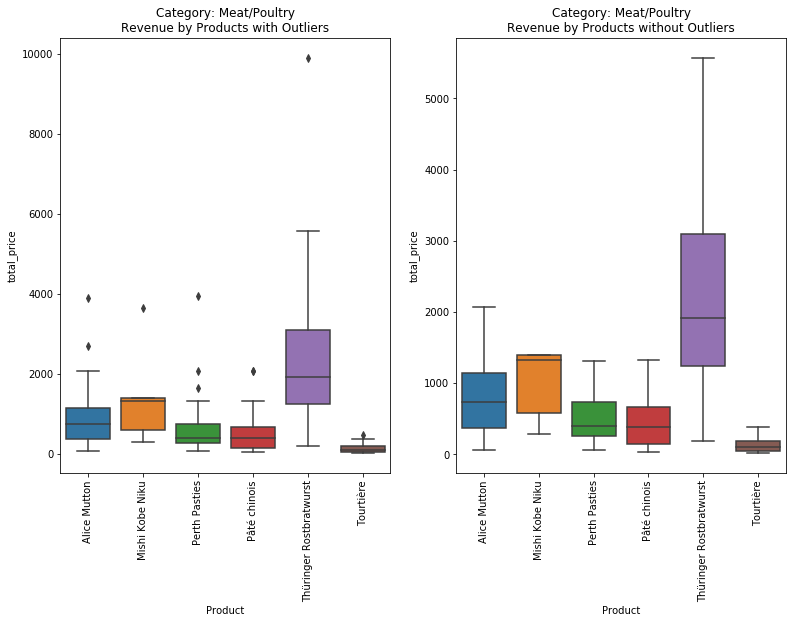

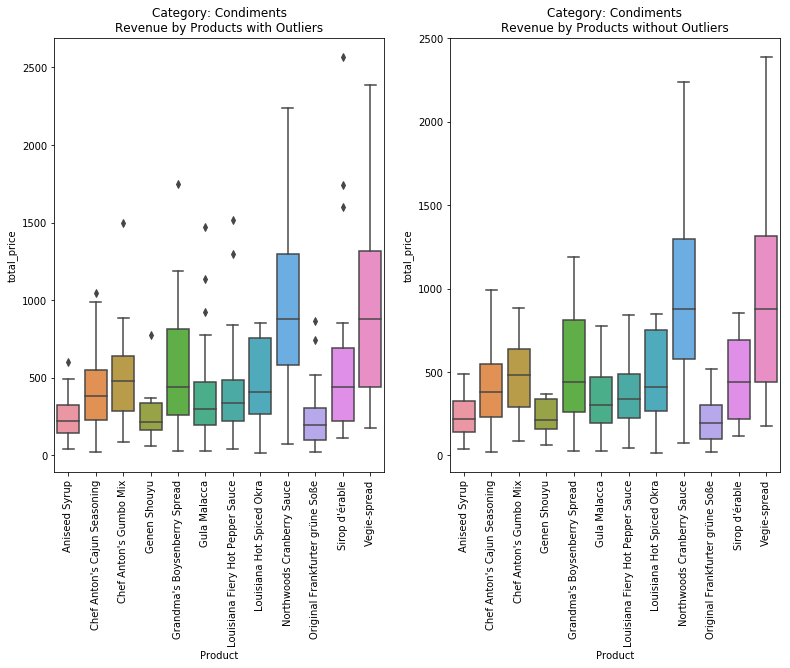

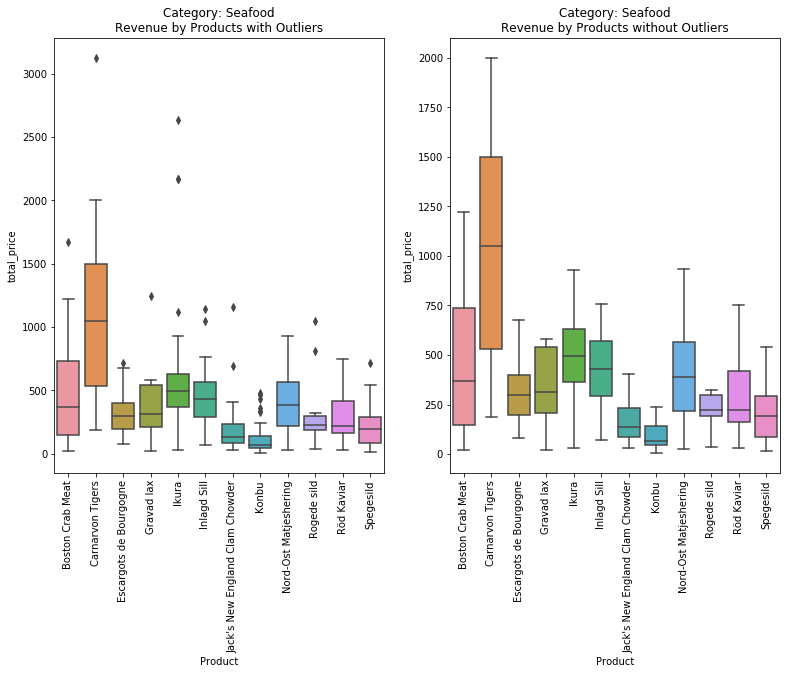

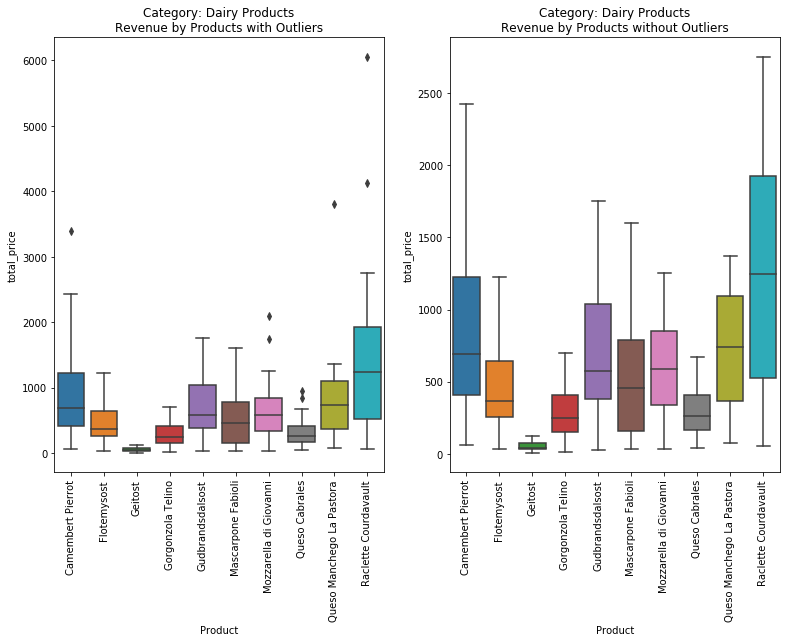

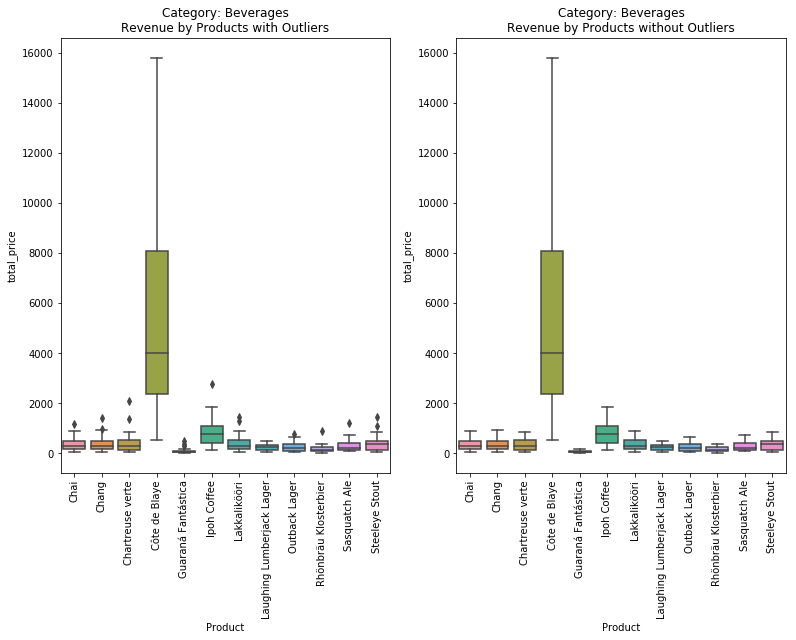

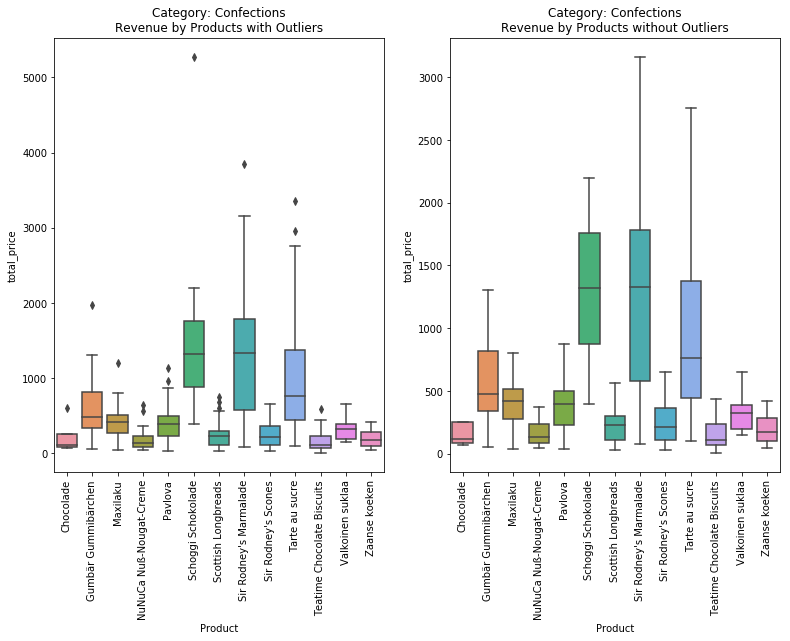

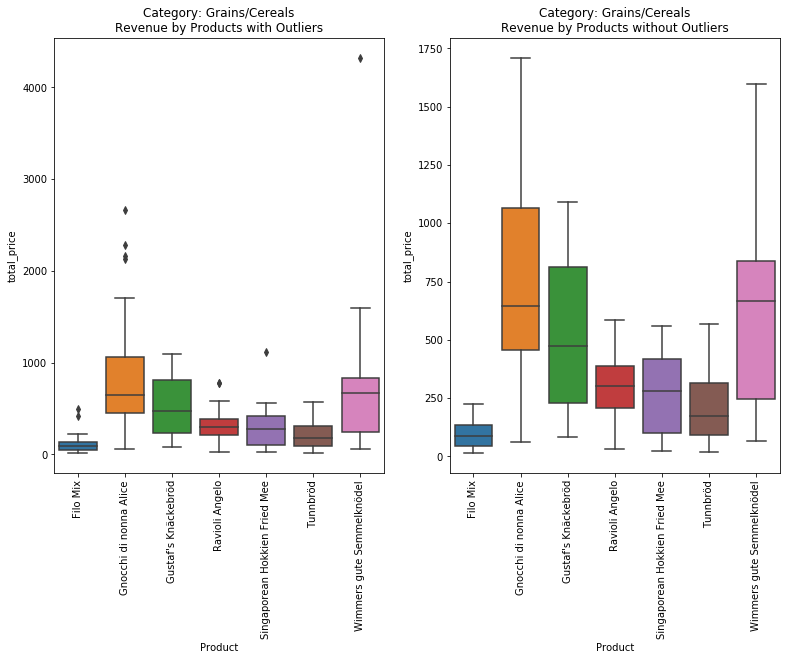

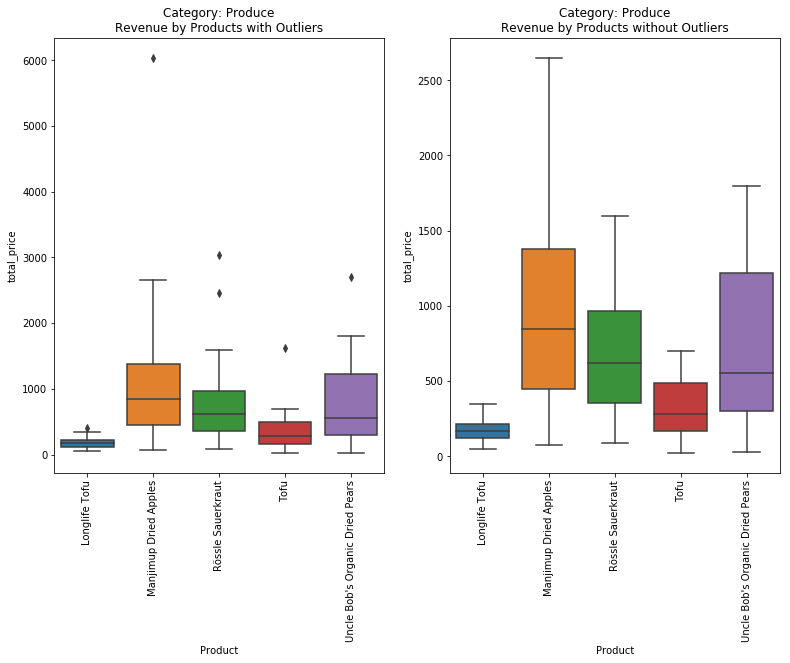

In [87]:
for cat in df.CategoryName.unique():

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(13,8))
    
    sns.boxplot(x='Product', y='total_price', data=df[df.CategoryName==cat], ax=ax1, showfliers=True)
    ax1.set_title(f'Category: {cat}\nRevenue by Products with Outliers')
    ax1.tick_params(axis='x', labelrotation=90)

    sns.boxplot(x='Product', y='total_price', data=df[df.CategoryName==cat], ax=ax2,showfliers=False)
    ax2.set_title(f'Category: {cat}\nRevenue by Products without Outliers')
    ax2.tick_params(axis='x', labelrotation=90)
    
    plt.show()

In [11]:
# ANOVA Test on total price
alpha = 0.05

formula = f'total_price ~ C(Product)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm)
table['reject_null'] = table['PR(>F)'] < alpha
pd.DataFrame(table)

,df,sum_sq,mean_sq,F,PR(>F),reject_null
C(Product),76.0,9.922766e+08,1.305627e+07,26.556033,1.167716e-246,True
Residual,2001.0,9.837914e+08,4.916499e+05,NaN,NaN,False


In [126]:
## Tukey Test on Products of the same Category & statistical power##
from IPython.core.display import HTML

for cat in df.CategoryName.unique():
    # Set up the data for comparison (creates a specialised object)
    MultiComp = MultiComparison(data=df[df.CategoryName==cat].total_price, 
                                groups=df[df.CategoryName==cat].Product)
    result = MultiComp.tukeyhsd()
    # Show all pair-wise comparisons:
    # Print the comparisons
    
    print(f'{cat}')

    df_result = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
    
    e_size = []
    for (a,b) in zip(df_result.group1, df_result.group2):
        e_size.append(abs(fs.cohen_d(df[df.Product==a].total_price,df[df.Product==b].total_price)))
    df_result['effect_size'] = e_size
    df_result['stat_power'] = df_result.effect_size.apply(lambda x, y=df_result: 
                                                          tt_ind_solve_power(effect_size=x, nobs1=100, alpha=0.05))
    display(HTML(df_result.to_html()))  
    print('\n')

Meat/Poultry


,group1,group2,meandiff,lower,upper,reject,effect_size,stat_power
0,Alice Mutton,Mishi Kobe Niku,547.8320,-895.5725,1991.2365,False,0.638850,0.994384
1,Alice Mutton,Perth Pasties,-216.2897,-974.4029,541.8234,False,0.279379,0.502419
2,Alice Mutton,Pâté chinois,-361.8930,-1100.3164,376.5304,False,0.546585,0.970363
3,Alice Mutton,Thüringer Rostbratwurst,1614.0530,875.6296,2352.4764,True,1.080351,1.000000
4,Alice Mutton,Tourtière,-765.4098,-1487.1120,-43.7075,True,1.390735,1.000000
5,Mishi Kobe Niku,Perth Pasties,-764.1217,-2226.0718,697.8283,False,0.870485,1.000000
6,Mishi Kobe Niku,Pâté chinois,-909.7250,-2361.5623,542.1123,False,1.333849,1.000000
7,Mishi Kobe Niku,Thüringer Rostbratwurst,1066.2210,-385.6163,2518.0583,False,0.553317,0.973415
8,Mishi Kobe Niku,Tourtière,-1313.2418,-2756.6463,130.1627,False,2.761970,1.000000
9,Perth Pasties,Pâté chinois,-145.6033,-919.6515,628.4449,False,0.222358,0.346530




Condiments


,group1,group2,meandiff,lower,upper,reject,effect_size,stat_power
0,Aniseed Syrup,Chef Anton's Cajun Seasoning,187.4944,-327.5186,702.5075,False,0.736903,0.999371
1,Aniseed Syrup,Chef Anton's Gumbo Mix,293.0222,-316.3494,902.3939,False,0.943332,1.000000
2,Aniseed Syrup,Genen Shouyu,43.8042,-647.1583,734.7667,False,0.216677,0.331934
3,Aniseed Syrup,Grandma's Boysenberry Spread,341.0833,-223.0852,905.2518,False,0.904428,1.000000
4,Aniseed Syrup,Gula Malacca,159.4977,-329.0866,648.0820,False,0.538686,0.966419
5,Aniseed Syrup,Louisiana Fiery Hot Pepper Sauce,179.7674,-288.0164,647.5512,False,0.619759,0.991826
6,Aniseed Syrup,Louisiana Hot Spiced Okra,219.9048,-437.3317,877.1412,False,0.913767,1.000000
7,Aniseed Syrup,Northwoods Cranberry Sauce,730.6667,166.4982,1294.8352,True,1.583614,1.000000
8,Aniseed Syrup,Original Frankfurter grüne Soße,-12.9103,-473.5519,447.7314,False,0.067928,0.076560
9,Aniseed Syrup,Sirop d'érable,344.3583,-144.2259,832.9426,False,0.699010,0.998455




Seafood


,group1,group2,meandiff,lower,upper,reject,effect_size,stat_power
0,Boston Crab Meat,Carnarvon Tigers,615.8817,321.9783,909.7851,True,1.182985,1.000000
1,Boston Crab Meat,Escargots de Bourgogne,-130.2684,-470.4955,209.9587,False,0.393792,0.791329
2,Boston Crab Meat,Gravad lax,-16.4914,-527.5317,494.5488,False,0.042506,0.060311
3,Boston Crab Meat,Ikura,177.8588,-102.4561,458.1736,False,0.359713,0.716085
4,Boston Crab Meat,Inlagd Sill,-18.2228,-303.5041,267.0585,False,0.055005,0.067333
5,Boston Crab Meat,Jack's New England Clam Chowder,-278.7919,-535.2147,-22.3691,True,0.960611,1.000000
6,Boston Crab Meat,Konbu,-338.1366,-604.6205,-71.6526,True,1.204176,1.000000
7,Boston Crab Meat,Nord-Ost Matjeshering,-40.3859,-325.6672,244.8954,False,0.119845,0.134604
8,Boston Crab Meat,Rogede sild,-154.6885,-519.0375,209.6606,False,0.436751,0.867215
9,Boston Crab Meat,Röd Kaviar,-179.0438,-543.3928,185.3052,False,0.527092,0.959854




Dairy Products


,group1,group2,meandiff,lower,upper,reject,effect_size,stat_power
0,Camembert Pierrot,Flotemysost,-452.3265,-852.1161,-52.5369,True,0.805574,0.999896
1,Camembert Pierrot,Geitost,-864.9977,-1307.5356,-422.4599,True,1.548605,1.000000
2,Camembert Pierrot,Gorgonzola Telino,-622.4035,-1002.0984,-242.7086,True,1.211321,1.000000
3,Camembert Pierrot,Gudbrandsdalsost,-191.3790,-629.2590,246.5009,False,0.306834,0.578947
4,Camembert Pierrot,Mascarpone Fabioli,-355.7937,-913.1674,201.5801,False,0.541726,0.967985
5,Camembert Pierrot,Mozzarella di Giovanni,-253.5591,-668.1887,161.0706,False,0.413204,0.828342
6,Camembert Pierrot,Queso Cabrales,-600.9660,-1022.5671,-179.3649,True,1.073256,1.000000
7,Camembert Pierrot,Queso Manchego La Pastora,-40.5239,-612.9355,531.8877,False,0.053177,0.066190
8,Camembert Pierrot,Raclette Courdavault,435.9136,59.8501,811.9771,True,0.473389,0.914832
9,Flotemysost,Geitost,-412.6712,-870.9801,45.6377,False,1.706583,1.000000




Beverages


,group1,group2,meandiff,lower,upper,reject,effect_size,stat_power
0,Chai,Chang,21.8090,-775.5616,819.1795,False,0.080500,0.087496
1,Chai,Chartreuse verte,60.0930,-812.4608,932.6468,False,0.168770,0.220773
2,Chai,Côte de Blaye,5523.0026,4580.8029,6465.2023,True,2.059048,1.000000
3,Chai,Guaraná Fantástica,-262.7877,-1034.3040,508.7286,False,1.419720,1.000000
4,Chai,Ipoh Coffee,478.4519,-429.9751,1386.8789,False,1.123798,1.000000
5,Chai,Lakkalikööri,42.1788,-784.1282,868.4858,False,0.141058,0.168257
6,Chai,Laughing Lumberjack Lager,-110.0450,-1371.7557,1151.6657,False,0.445077,0.879382
7,Chai,Outback Lager,-83.8658,-904.7935,737.0619,False,0.363507,0.725061
8,Chai,Rhönbräu Klosterbier,-175.0752,-968.3059,618.1555,False,0.823340,0.999937
9,Chai,Sasquatch Ale,-17.3485,-1056.0586,1021.3615,False,0.063791,0.073386




Confections


,group1,group2,meandiff,lower,upper,reject,effect_size,stat_power
0,Chocolade,Gumbär Gummibärchen,384.6583,-493.6981,1263.0148,False,0.927526,1.000000
1,Chocolade,Maxilaku,199.3925,-702.6011,1101.3861,False,0.754983,0.999600
2,Chocolade,NuNuCa Nuß-Nougat-Creme,-19.2375,-929.5446,891.0696,False,0.101713,0.110436
3,Chocolade,Pavlova,175.3294,-685.5207,1036.1795,False,0.691657,0.998175
4,Chocolade,Schoggi Schokolade,1452.7264,463.1182,2442.3345,True,1.174111,1.000000
5,Chocolade,Scottish Longbreads,31.2566,-839.2362,901.7494,False,0.154461,0.192474
6,Chocolade,Sir Rodney's Marmalade,1258.1882,324.5361,2191.8403,True,1.305154,1.000000
7,Chocolade,Sir Rodney's Scones,17.5181,-850.4257,885.4618,False,0.098092,0.106117
8,Chocolade,Tarte au sucre,759.0244,-98.0014,1616.0502,False,1.003814,1.000000
9,Chocolade,Teatime Chocolate Biscuits,-63.2008,-931.1446,804.7429,False,0.415912,0.833150




Grains/Cereals


,group1,group2,meandiff,lower,upper,reject,effect_size,stat_power
0,Filo Mix,Gnocchi di nonna Alice,709.1143,385.0375,1033.1910,True,1.538631,1.000000
1,Filo Mix,Gustaf's Knäckebröd,392.8122,-52.5025,838.1270,False,1.779643,1.000000
2,Filo Mix,Ravioli Angelo,228.3359,-160.0164,616.6881,False,1.450498,1.000000
3,Filo Mix,Singaporean Hokkien Fried Mee,177.9222,-186.7826,542.6270,False,0.968345,1.000000
4,Filo Mix,Tunnbröd,114.1572,-284.7511,513.0655,False,0.817629,0.999926
5,Filo Mix,Wimmers gute Semmelknödel,616.0045,257.3172,974.6917,True,1.083325,1.000000
6,Gnocchi di nonna Alice,Gustaf's Knäckebröd,-316.3020,-726.0618,93.4577,False,0.601094,0.988387
7,Gnocchi di nonna Alice,Ravioli Angelo,-480.7784,-827.7875,-133.7693,True,0.992475,1.000000
8,Gnocchi di nonna Alice,Singaporean Hokkien Fried Mee,-531.1920,-851.5159,-210.8681,True,1.120535,1.000000
9,Gnocchi di nonna Alice,Tunnbröd,-594.9570,-953.7406,-236.1735,True,1.221730,1.000000




Produce


,group1,group2,meandiff,lower,upper,reject,effect_size,stat_power
0,Longlife Tofu,Manjimup Dried Apples,885.1833,239.7386,1530.6281,True,0.992581,1.000000
1,Longlife Tofu,Rössle Sauerkraut,587.4214,-78.5188,1253.3616,False,1.068329,1.000000
2,Longlife Tofu,Tofu,182.8032,-528.4423,894.0487,False,0.652271,0.995728
3,Longlife Tofu,Uncle Bob's Organic Dried Pears,593.7525,-82.6460,1270.1510,False,1.077098,1.000000
4,Manjimup Dried Apples,Rössle Sauerkraut,-297.7619,-782.7123,187.1884,False,0.337751,0.661557
5,Manjimup Dried Apples,Tofu,-702.3801,-1247.8805,-156.8797,True,0.822324,0.999935
6,Manjimup Dried Apples,Uncle Bob's Organic Dried Pears,-291.4309,-790.6457,207.7840,False,0.325945,0.630680
7,Rössle Sauerkraut,Tofu,-404.6182,-974.2216,164.9852,False,0.735899,0.999355
8,Rössle Sauerkraut,Uncle Bob's Organic Dried Pears,6.3311,-519.1143,531.7764,False,0.009629,0.050526
9,Tofu,Uncle Bob's Organic Dried Pears,410.9493,-170.8468,992.7453,False,0.745824,0.999496


# Conclusion

Based on these results, there seems to be certain goods that have a significant impact on revenue generated within their respective categories.  We have very high statistical power with these along with high effect sizes as well.  

Below, the respective goods are listed by their categories:

**Grains/Cereal**

_Gnocchi di nonna Alice & Wimmers gute Semmelknödel_ are the two products that stood out the most compared to others within the grain/cereal category.  They both share the top spot for the most significant grain products that have impacts on sales.	
_______________________
**Meat/Poultry**

The meats/poltry did not have a specific good that stood out more compared to the others
_______________________
**Condiments**

There was not a specific condiment that stood out compared to most of the other products solds within that category.
_______________________
**Seafood**

Of the seafood, _Carnarvon Tigers_ stood out compared to all other products.  
**Based on the data, I recommend marketing this product even more to clients.**
________________________
**Produce:**

There was not a specifc produce that significantly stood out apart from the other options
________________________
**Confections:**

_Schoggi Schokolade_ was one product that stood apart from many of the other products sold by the company.
This good has a more significant stastical impact than all other confections, with the exception of _Sir Rodney's Marmalade._
**_Schoggi Schokolade_** should be marketed 
________________________

**Beverages**

Of the beverages, Côte de Blaye	is the beverage that has the most significant impact on sales, over all other beverages.
**This product should be marketed more heavily due to its statistic significance**
________________________

**Dairy Products**

There was not a specific dairy product that outperformed a majority of the others sold.  They all tend to have the same amount of significance statistically.
________________________